> SASpy模块打通了Python与SAS之间的连接。有了SASpy模块，我们就能够在Python中操控SAS。本文将首先介绍SASpy模块的一些基本方法，最后通过一个聚类分析的例子，来展示如何在Python中调用SAS的机器学习过程，以及对聚类结果的可视化。

1. 需要Python3.X及以上，SAS9.4及以上，需要Java环境
2. 论是本地SAS还是远程服务器上的SAS，都可以使用SASpy调用SAS进程
3. 可以在Python和SAS之间传递数据（也就是Pandas数据框与SAS数据集可以相互转换）
4. 某些Pandas方法可以直接在SAS数据集上使用（实际背后进行了转化）
5. 可以调用SAS的各种模块，比如统计stat、质量控制qc、预测ets、机器学习(EM模块)等

In [69]:
import saspy
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
sas = saspy.SASsession()
sas.teach_me_SAS(True)

Using SAS Config named: winlocal
SAS Connection established. Subprocess id is 9076



# 一.  SASpy基本操作

> 有一些操作不能成功

In [6]:
sas.saslog() # 显示SAS Log

'\x0c1                                                             SAS 系统                         2019年10月16日星期三 下午01时43分31秒\n\nNOTE: Copyright (c) 2002-2012 by SAS Institute Inc., Cary, NC, USA. \nNOTE: SAS (r) Proprietary Software 9.4 (TS1M2 DBCS3170) \n      Licensed to NATIONAL PINGTUNG UNI OF SCIENCE&TECH, Site 12001462.\nNOTE: 该会话正在平台 X64_8PRO  上执行。\n\n\n\nNOTE: Updated analytical products:\n      \n      SAS/STAT 13.2\n      SAS/ETS 13.2\n      SAS/OR 13.2\n      SAS/IML 13.2\n      SAS/QC 13.2\n\nNOTE: Additional host information:\n\n X64_8PRO WIN 6.2.9200  Workstation\n\nNOTE: “SAS 初始化”所用时间（总处理时间）:\n      实际时间          0.00 秒\n      CPU 时间          0.00 秒\n      \n1          ;*\';*";*/;\n2          options svgtitle=\'svgtitle\'; options validvarname=any pagesize=max nosyntaxcheck; ods graphics on;\n3          \n4          ;*\';*";*/;\n5          %put E3969440A681A2408885998500000001;\nE3969440A681A2408885998500000001\n6          \n\x0c2                                         

In [7]:
sas.saslib("my 'D:\'") # 建立一个SAS逻辑库my

libname my 'D:'    ;


In [10]:
sas.exist("work.class") # 判断work逻辑库下class数据集是否存在

False

In [11]:
sas.exist("sashelp.class")

True

In [15]:
cars = sas.sasdata('cars', 'sashelp') # 获取sashelp逻辑库的cars数据集
cars

Libref  = sashelp
Table   = cars
Dsopts  = {}
Results = Pandas

In [20]:
df_class = sas.sd2df(table='class', libref='sashelp') # 获取sashelp逻辑库class数据集(pandas数据框)
df_class

too complicated to show the code, read the source :), sorry.


In [21]:
df_air = sas.sd2df('sashelp.air') # 获取sashelp逻辑库ari数据集(pandas数据框)
df_air

too complicated to show the code, read the source :), sorry.


In [25]:
df = pd.DataFrame({"A":[1, 2], "B":[3, 4]})
df

,A,B
0,1,3
1,2,4


In [ ]:
sas_df1 = sas.df2sd(df, table='sas_df', libref='work') # 将Python的df数据框转为sas的sas_df数据集

In [26]:
sas_df2 = sas.df2sd(df) # 将Python的df数据框转为sas数据集

too complicated to show the code, read the source :), sorry.


In [27]:
sas.write_csv(r"D:\export_csv.csv", "class", "sashelp")

filename x "D:\export_csv.csv";
options nosource;
proc export data=sashelp.class outfile=x dbms=csv replace;  run
;options source;

None


# 二. 提交SAS代码

> 可以在Python中直接提交“原汁原味”的SAS代码吗？当然可以，使用sas.submit()方法，将所有代码都放入submit()中，像'''SAS code'''这样，将SAS代码包裹起来。

In [31]:
sas.set_results("Text")
sas.set_batch(True)
results = sas.submit(
    '''
    options nocenter nodate;
    option validvarname=any;
    ods listing;
    data class;
       set sashelp.class;
       where age<14;
    run;
    
    proc sql;
        select sex, mean(height) as 平均身高
    from 
        class
    group by
        sex;
    quit;
    
    proc means data=sashelp.cars; run;
    '''
)
print(results['LST'])

# 三. 一个好玩的功能 teach_me_SAS

In [34]:
sas.teach_me_SAS(True)
cars.columnsInfo()

AttributeError: 'SASdata' object has no attribute 'columnsInfo'

# 四. 利用SAS模块进行机器学习

> 以iris鸢尾花数据集聚类模型为例

In [38]:
util = sas.sasutil()
ml   = sas.sasml()
stat = sas.sasstat()
ets  = sas.sasets()
qc   = sas.sasqc()

In [41]:
dir(ml)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'hp4score',
 'hpbnet',
 'hpcluster',
 'hpforest',
 'hpneural',
 'logger',
 'sas',
 'sasproduct',
 'treeboost']

In [55]:
from sklearn.datasets import load_iris
data_x, data_y, cols = load_iris()['data'], load_iris()['target'], load_iris()['feature_names']


iris = pd.DataFrame(data_x, columns=['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth'])

In [56]:
iris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [59]:
iris_sas = sas.df2sd(iris)

In [61]:
sas.set_batch(False)
sas.set_results("Pandas")

sas.teach_me_SAS(False)
inputs = 'SepalLength SepalWidth PetalLength PetalWidth'

result = ml.hpcluster(data=iris_sas, input=inputs)
print(dir(result))

['CLUSTERSUM', 'DATAACCESSINFO', 'DESCSTATS', 'ITERSTATS', 'LOG', 'MODELINFO', 'NOBS', 'PERFORMANCEINFO', 'WITHINCLUSSTATS']


In [62]:
result.MODELINFO

,Parameter,Setting
0,最大迭代,10
1,停止准则,聚类更改
2,停止准则值,0
3,聚类,6
4,种子初始化,12345
5,距离,欧氏


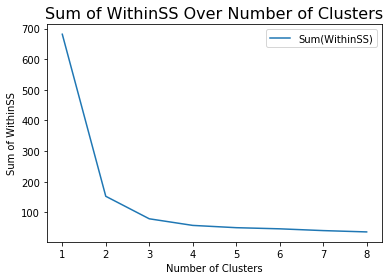

In [70]:
wss = []
for i in range(1, 9):
    test = ml.hpcluster(data=iris_sas, input=inputs, procopts=('maxclusters=%d' %i))
    wss.append(test.clustersum.SSE.sum())
    
    
wsspd = pd.DataFrame(wss, index=range(1, len(wss)+1))
plt.plot(wsspd)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of WithinSS")
plt.title("Sum of WithinSS Over Number of Clusters", fontsize=16)

plt.legend(["Sum(WithinSS)"], loc='best')
plt.show()

## 聚类结果可视化

# 参考文献

1. [SASpy模块，利用Python操作SAS](https://cloud.tencent.com/developer/news/231802)